# Predicting auction house binary price returns on Elixir of the Mongoose

## Introduction
Starting this project, i knew only that i wanted to do something cool and not just download a complete dataset from kaggle. Being an avid gamer during my youth i started looking for different ways to collect data from games i used to play, doing this i found an API with historical Auction House price/quantity data for different items.<br><br>
At first, i had an idea of testing if the price data correlate with Benfords Law (it didn't), but this was a bit boring... And i wanted to do something cool! Ever since starting at Högskolan Dalarna i've been fascinated by neural networks after watching documentaries about it, but it always seemed to be out of grasp.. Whilst considering ideas i emailed my teacher Arend to review them, and he replied that for predicting the prices i would have to use GRU's or LSTM's, the fact that this was in the realm of possibility for me to do settled it. I was going to give neural networks a go!<br><br>
I started reading "Tech Articles" about LSTM's and GRU's for predicting the Stock Market achieving results of 90% accuracy, and i thought: Hey, it must be easy to then predict a virtual economy, right? When i started to understand more about the code in the tutorials and articles, i realised they all did "one-step" predictions and presented it like a proper prediction of future prices. But in reality, theese models could only predict the future if they already had some knowledge about it, which is counterintuitive. From here i learned that stock market price changes are most likely random walks, and even the best models seems to have trouble predicting singular positive accuracies above 0.5. But are there more patterns in a virtual economy? Just by thinking of it my belief is that World of Warcrafts economy is more cyclical in nature, unless disturbed by a game update (patch) the prices would be reflected mostly by quantity, which maybe is reflected by the concurrency of players?<br><br>
From here i started from scratch, all the way back to linear/logistic regression and worked my way to ANN's, RNN's and then LSTM's to get a greater understanding of what happens under the hood. During this journey i realised that many things can be concretized, even the most "buzz-wordiest" of concepts!


## Question of discovery:
1. Are the price movements on World of Warcrafts Elixir of the Mongoose random walks?
2. Will an LSTM model be able to binary classify price returns at a accuracy higher than 0.5 for Elixir of the Mongoose without overfitting to the training data?
3. Can i create a model which a player could use to make gold of the Auction House by classifying the price return of Elixir of the Mongoose?

## Table of contents
### 1.0 Data Pre-processing
* __1.1 Exploring the data__
* __1.2 Preparing features for our model__

### 2.0 Train LSTM for binary classification of price returns
* __2.1 Creating the model__
* __2.2 Training the model__
* __2.3 Loss__
* __2.4 Accuracy__
* __2.5 Summary and shapes__

### 3.0 Testing the model
* __3.1 Multi-step forecast with entire validation set__
* __3.2 Multi-step predictions weekwise__
* __3.3 Algorithm to test predicted results of other steps__
* __3.4 Multi-step prediction with 19 steps__
* __3.5 Evaluation on the 18 days of data since training model__

### 4.0 Discussion

### 5.0 Results
* __5.1 Post Mortem__

In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from tensorflow import keras

# 1.0 Data Pre-processing

To get started we send a get request to the nexushub api with below parameters, we then dump the data into a json file which we then convert to csv. If you paste the url for the get request, we see that the data is from multiple daily measurements, therein lies a problem: The number of measurements are not equal and the current time of the measurements are not the same daily.<br><br>
To fix this problem i decided to group the rows by date and then take averages by dividing "market value" with "quantity".

In [98]:
jsonSoldItems = requests.get("https://api.nexushub.co/wow-classic/v1/items/shazzrah-horde/elixir-of-the-mongoose/prices?timerange=500")
data = jsonSoldItems.json()

with open('data.json', 'w') as f:
    json.dump(data['data'], f)
    
df = pd.read_json('data.json')
df.to_csv('data.csv')
df = pd.read_csv('data.csv')

df['scannedAt'] = pd.to_datetime(df['scannedAt'])
df['date'] = df['scannedAt'].dt.date
df['date'] = pd.to_datetime(df['date'])
df = df.groupby(pd.Grouper(key='date',freq='D')).sum()

for i in df.index:
    df.at[i, 'minBuyout']=df.at[i,'minBuyout']/df.at[i,'quantity'].astype(float)
    df.at[i, 'avgBuyout']=df.at[i,'marketValue']/df.at[i,'quantity'].astype(float)

In [99]:
df.head()

,Unnamed: 0,marketValue,minBuyout,quantity,avgBuyout
date,,,,,
2019-12-15,0,37044,312,117,316.615385
2019-12-16,1,37407,218,166,225.343373
2019-12-17,2,36964,251,146,253.178082
2019-12-18,3,41092,169,236,174.118644
2019-12-19,4,40850,182,222,184.009009


## 1.1 Exploring the data

In [100]:
series = df['avgBuyout'].values.reshape(-1,1)

Reshape to 1d vector for plot

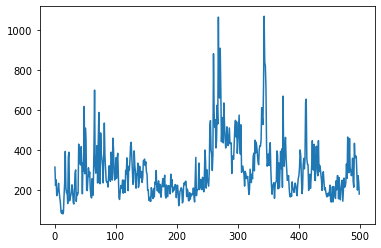

In [101]:
plt.plot(series)

Plot above shows price movements for the last 500 days, it looks to follow some sort of pattern other than a slow decline to around 220 followed by a run-up at around 250 and then another at 350. The two "candles", or large price increases correlate with the release of the AQ40 (29 July 2020) raid and the Naxxramas (December 1, 2020) raid, by increasing the demand for raid consumables like Elixir of the Mongoose. Our model will find it hard to explain theese two candles, as they're not explained by implicit data but by factors from the outside, a large patch altering the game heavilly. The subsequent peaks of the price seems to diminish over time, probably due to loss in player interest.<br><br>
Other than theese two candles and the runup for the first, the data almost looks like a noisy sinewave. I.e. not to irregular and with some patterns with the two candles almost looking like disruptions. Are the prices cyclical other than explicit updates?<br><br>
**About game updates:** This data is from the "Classic" version of the game, of which all raid content has now been released. Subsequently we could expect not to see more disruptions in price in the future. With this in mind i also tried to make a model with 130-250 samples in an attempt to avoid training on the time of the Naxxramas raid release which looks to have spiked the price, the volume of samples for this was however to low to make a good predictive model. In a year i except you could make a more accurate model if my theory of price disruptions trough raid releases is right. The price "should" follow a slow cyclical decline from here on out.

**Weekends?**<br>
https://www.statista.com/statistics/502149/average-daily-time-playing-games-and-using-computer-us-by-age/
<br><br>
After doing some testing, the model does not seem to find a pattern with binary encoded days (0-6) for mon-sun. It is common knowledge for gamers that player counts are higher during weekends, especially for MMORPG's and FPS games. World of warcraft no longer has concurrent player data public since the explansion "Wrath of the lich King", but i found some sources showing data that indicates a higher player count during weekends. So let's add a binary classifier instead, 0 for weekday and 1 for weekend.

In [102]:
import datetime
df['weekDay'] = df.index.dayofweek
df['prevBuyout'] = df['avgBuyout'].shift(1)
#The return is (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['avgBuyout'] - df['prevBuyout']) / df['prevBuyout']

for i in df.index:
    if(df.at[i, 'weekDay']>=5):
        df.at[i, 'weekDay'] = 1
    else:
        df.at[i, 'weekDay'] = 0

In [103]:
df.head()

,Unnamed: 0,marketValue,minBuyout,quantity,avgBuyout,weekDay,prevBuyout,Return
date,,,,,,,,
2019-12-15,0,37044,312,117,316.615385,1,NaN,NaN
2019-12-16,1,37407,218,166,225.343373,0,316.615385,-0.288274
2019-12-17,2,36964,251,146,253.178082,0,225.343373,0.123521
2019-12-18,3,41092,169,236,174.118644,0,253.178082,-0.312268
2019-12-19,4,40850,182,222,184.009009,0,174.118644,0.056802


In [104]:
df_weekend = df[df['weekDay'] == 1]
df_weekday = df[df['weekDay'] == 0]

In [105]:
print("weekEnd:",df_weekend.avgBuyout.mean())
print("WeekDay:",df_weekday.avgBuyout.mean())

weekEnd: 288.42017590510534
WeekDay: 304.8170470650649


In [106]:
print("weekEnd:",df_weekend.marketValue.mean())
print("WeekDay:",df_weekday.marketValue.mean())

weekEnd: 1577478.7342657342
WeekDay: 1612629.6218487395


In [107]:
print("weekEnd:",df_weekend.quantity.mean())
print("WeekDay:",df_weekday.quantity.mean())

weekEnd: 6110.937062937063
WeekDay: 5824.134453781513


**Differences**<br><br>
By looking at the different means of the data that is weekend or weekday, we see that the quantity of Elixir of the Mongoose goes up during the weekends which drives the average buyout price down by around 5.6%.

<AxesSubplot:>

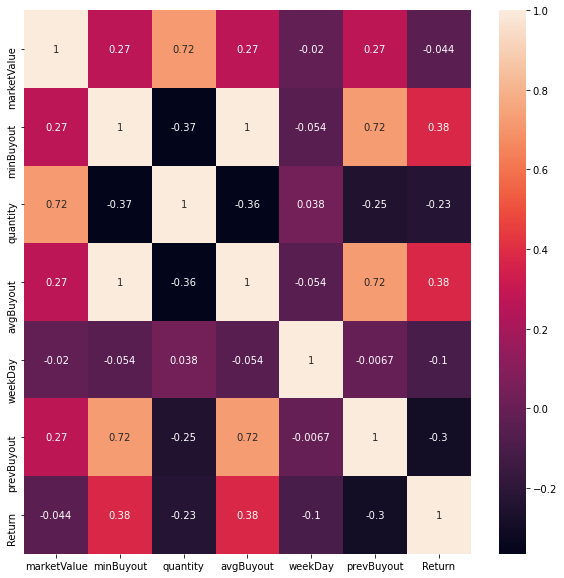

In [5]:
correlation_mat = df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_mat, annot = True)

This correlation matrix is interesting, if we look at Return as a target we see that avgBuyout is high at 0.38 along with minBuyout. Theese two numbers are very similar, it seems as if price ranges don't move to heavily daily and also that avg buyout prices are very close to the minimum buyout prices. This could indicate that the value of Elixir of the Mongoose is fairly distinct and not very prone to volatility (except for the mentioned raid releases).<br><br>
After doing some testing i noticed that the model doesnt really see a difference in the data: avgBuyout, minBuyout & prevBuyout. Theese three are really measurements of the same thing, two are similar and one is just of a previous timestep which our model already can look at by its very nature. After several tests i came to the conclusion that the features with the best results are: avgBuyout, quantity and weekDay. Even though quantity and weekDay score lower in the correlation matrix, they add some new explanatatory power not already covered in the price features which is reflected in the accuracy of the model.

## 1.2 Preparing features for our model

N x T x D<br><br>
N = Length of series - T<br>
T = Length of each signal (timesteps in the sequence)<br>
D = Number of features (dimensions)<br><br>
Here we select our dependant target and independant features and scale them all except for the binary classifier of 'weekDay'. We must also take T into consideration when preparing the data as the target of y is delayed by T 10 timesteps. X_train and X_test are made as 3-D numpy arrays of N x T x D. Y_train is a 1-D np array of size as Ntrain, which is the training subset of the dataframe. Y-test is the same as Y_train but with a length of N minus the length of the training proportion.

In [108]:
T = 10 #Steps to look at before predictions of next day, in our case 10 days of data to predict 11th.

In [109]:
Ntrain = len(df.quantity) * 7 // 8

scaled_features = df.copy()

col_names = ['avgBuyout', 'quantity']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values[:Ntrain + T])
features = scaler.transform(features.values)
scaled_features[col_names] = features



In [110]:
input_data = scaled_features[['avgBuyout', 'quantity', 'weekDay']].values
targets = scaled_features['Return'].values

In [111]:
D = input_data.shape[1]
N = len(input_data) - T #(If T=10 and we have 11 datapoints, we have one sample)

In [112]:
scaled_features.head()

,Unnamed: 0,marketValue,minBuyout,quantity,avgBuyout,weekDay,prevBuyout,Return
date,,,,,,,,
2019-12-15,0,37044,312,-1.676895,0.074530,1,NaN,NaN
2019-12-16,1,37407,218,-1.663029,-0.570758,0,316.615385,-0.288274
2019-12-17,2,36964,251,-1.668689,-0.373968,0,225.343373,0.123521
2019-12-18,3,41092,169,-1.643221,-0.932914,0,253.178082,-0.312268
2019-12-19,4,40850,182,-1.647182,-0.862990,0,174.118644,0.056802


Loop in range of Ntrain to populate X_train and Y_train with indexed data from input_data and targets. Targets (return) becomes a boolean for binary classification.

In [113]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
    X_train[t, :, :] = input_data[t:t+T] # t - t+T (0-(0+10)) First iteration 0-10 of Ntrain, sequence feature vector
    Y_train[t] = (targets[t+T] > 0) #Boolean, true if [t+T] is > 0

Loop from 0 too length of Ntrain - T to populate X_test and Y_test. u refers do index of X_test and Y_test. Since we are indexing our original data, we must then offset it by Ntrain. Hence, t = u + Ntrain. And each sequence is t..T

In [114]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
    #u counts from 0...(N-Ntrain)
    #t counts from Ntrain...N
    t = u + Ntrain
    X_test[u, :, :] = input_data[t:t+T]
    Y_test[u] = (targets[t+T] > 0)

# 2.0 Train LSTM for binary classification of price returns

Due to RNN's being prone to problems with long-term dependencies, using LSTM's proves to be the better choice when dealing with Time Series Prediction. Both RNN and LSTMS have a hidden state that is the weighted sum of the previous hidden state and new value, which allows remebering of older states. The weighted sum of previous states are however nested and will vanish over time for RNN's. LSTM's resolve this by gates which work like binary classifiers and decide what to remember/forget/keep, i.e. activating weighted sums in sigmoid functions which results in a value of 0 or 1. Of which result decides what data is important to keep(1), and what can be thrown away(0). LSTM's does this in three gates: Input, forget, and output gates. Theese gates together composes a "cell", each of theese gates including the cell itself has their own set of weights.

## 2.1 Creating the model

**Experimenting with widening / deepening the network, learning rate and epochs**<br>
I have mad multiple tests to widen / deepen the network with both more units, adding LSTM layers, adjusting learning rates and testing a wide range of epochs along with and without dropouts. A val_accuracy of 0.7 is the maximum i've achieved, after that the accuracy slowly declines no matter what i try. It seems to me like adding complexity to the model is not helping the results, i therefor decided to stick with my simple model of one layer, low learning rate and "few" epochs of training. Also, the more complex the model is, the more it seems prune to overfitting the training data. Adding a dropout did however fix this!<br><br>
**Choosing number of neurons and layers for LSTM.**<br>
Combining manual testing and some rule of thumbs i ended up with 30 hidden nodes in the LSTM of one layer. I came to this number by a rule of thumb found on stack overflow which stated: Nh = Nh / ((alpha * (Ni + No), or samples / (( a* (input + output))<br>
**500/((4 *(3+1)) = 31** (Round numbers are nicer, so i went with 30)<br><br>

**Model**<br>
Input of shape(10,3)<br>
LSTM layer with 30 neurons, or M = 30<br>
Dropout with rate 0.6<br>
One output neuron with a sigmoid activation function for logistic regression, or K = 1<br><br>
N = Number of samples (made of sequence length T)<br>
T = Sequence length<br>
D = Number of features<br>
M = Hidden units, dimensionality of the hidden state.<br>
K = Number of output units<br>
Input = T x D<br>
LSTM = N x T x M<br>
Output = N x T x K<br><br>
**Dropout**<br>
To handle our models overfitting, i applied a dropout between the LSTM layer and the output layer with a rate of 0.6 (drops 60%). I tried applying to dropout to various layers, for this model between LSTM and output provided better results. When applied between input layer and LSTM, there is a chance that the model does not see data which are important which could be detriment. By applying it between the LSTM and the output, only the activation functions that determine the output would drop which also prevents the adjusting of weights for the dropped neurons during back-propagation. This is beacuse activation functions of dropped neurons will become 0 and therefor ignored during backpropagation. This made huge difference on the models loss and accuracy, before applying this the model would overfit to the noise of the training data and the loss function would look all whack!<br>
**Binary_crossentropy**<br>
Since this is a classification problem, i decided to go with binary cross entropy as a loss function over MSE. While they both measure distances between the validiation data and the predictions, MSE will not penalize missclassifications as much. This is beacuse the decision boundary in a classification task is larger, and would result in a slower convergence.<br>
**Optimizer and learning rate**<br>
For optimizer we use Adam which is a replacement for stochastic gradient descent with the difference of adjusting the networks weight parameters separately instead of maintaining a single learning rate for all weights during training. I have not yet grasped the maths behind this algorithm, but in essence it can scale the learning rate by using squared gradients and take advantage of momentum by moving averages of the gradient. Even with this more dynamic optimizer i lowered the learning rate one decimal point from the default, it seems as if the model is very prune to overfitting on the training data.<br>
**Metrics**<br>
Since this is a classification problem, accuracy is used as a metric. This is simply the correct count of predictions compared to the validation data.<br>
**Batch_size**<br>
The hyperparameter which determines the number of samples the model goes trough before the internal parameters are updated, i.e. the weights are updated. I read that 32, 64 or 128 would be a good place to start generally. I tested a variety of sizes from 8 - 128 and found that around 32 gave better results when measuring the loss function and accuracy.<br>
In our case this means that the model will look at 32 samples which are of sequence length 10 before comparing the target prediction with the validation targets and generate the error measurement, using this measurement the model will move down along the error gradient and update the interal weights of the model. This is whats called a mini-batch gradient descent, the dropout mask is applied each new "mini-batch".<br>
**Epochs**<br>
Epoch is the hyperparameter that defines how many times the algorithm will work trough the entire dataset, meaning that for each epoch each sample of the training data has had an oppurtunity to update the internal parameters of the model. I tried a variety of epoch iterations, it seems as if at around 150-200 epochs the model would start overfitting to the noise of the training data and generate worse results, even with dropouts and low learning rates.

In [212]:
i = Input(shape=(T,D))
x = LSTM(30)(i)
drop_out = tf.nn.dropout(x, 0.6)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy'],
)

## 2.2 Training the model

In [213]:
r = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=150,
    validation_data=(X_test, Y_test),
)

Epoch 1/150
14/14 [==============================] - 1s 40ms/step - loss: 0.7019 - accuracy: 0.4691 - val_loss: 0.6968 - val_accuracy: 0.5094
Epoch 2/150
14/14 [==============================] - 0s 5ms/step - loss: 0.7011 - accuracy: 0.4760 - val_loss: 0.6962 - val_accuracy: 0.5094
Epoch 3/150
14/14 [==============================] - 0s 5ms/step - loss: 0.7002 - accuracy: 0.4851 - val_loss: 0.6956 - val_accuracy: 0.5094
Epoch 4/150
14/14 [==============================] - 0s 5ms/step - loss: 0.6994 - accuracy: 0.4897 - val_loss: 0.6951 - val_accuracy: 0.5094
Epoch 5/150
14/14 [==============================] - 0s 5ms/step - loss: 0.6988 - accuracy: 0.4897 - val_loss: 0.6944 - val_accuracy: 0.5094
Epoch 6/150
14/14 [==============================] - 0s 5ms/step - loss: 0.6981 - accuracy: 0.4966 - val_loss: 0.6939 - val_accuracy: 0.5094
Epoch 7/150
14/14 [==============================] - 0s 5ms/step - loss: 0.6975 - accuracy: 0.4897 - val_loss: 0.6935 - val_accuracy: 0.5094
Epoch 8/150


Epoch 59/150
14/14 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.5927 - val_loss: 0.6789 - val_accuracy: 0.6038
Epoch 60/150
14/14 [==============================] - 0s 4ms/step - loss: 0.6793 - accuracy: 0.5927 - val_loss: 0.6787 - val_accuracy: 0.6038
Epoch 61/150
14/14 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5927 - val_loss: 0.6784 - val_accuracy: 0.5849
Epoch 62/150
14/14 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.5904 - val_loss: 0.6783 - val_accuracy: 0.5849
Epoch 63/150
14/14 [==============================] - 0s 4ms/step - loss: 0.6786 - accuracy: 0.5927 - val_loss: 0.6780 - val_accuracy: 0.5849
Epoch 64/150
14/14 [==============================] - 0s 5ms/step - loss: 0.6783 - accuracy: 0.5950 - val_loss: 0.6778 - val_accuracy: 0.5849
Epoch 65/150
14/14 [==============================] - 0s 5ms/step - loss: 0.6781 - accuracy: 0.5950 - val_loss: 0.6776 - val_accuracy: 0.5849
Epoch 

## 2.3 Loss

The plotted loss does not display a typical L-shape. Other runs of the algorithm has provided a higher loss in the beginning, this did however result in overfitted models with less accuracy on the validation data and worse val_loss results. It seems as there is a tradeoff between bettering the training loss and worsening the val_loss. This result is the "in-between", sacrificing some loss for val_loss.

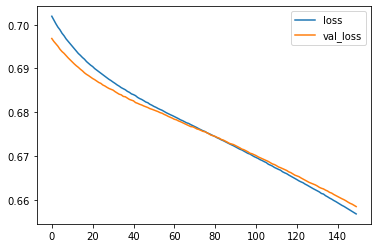

In [214]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

## 2.4 Accuracy

Since a dropout is applied, the val_accuracy is slightly higher than accuracy. This is normal beacuse the dropout does not deactivate cells whilst running on the validation data partition. It only does this while training to prevent overfitting, which it did in every case without using a dropout.

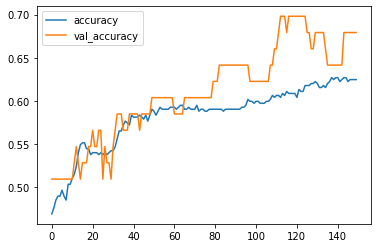

In [215]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

## 2.5 Summary and shapes

None = batch size (unknown prior to running for the model).<br><br>
Total params for each  layer is: (i×h + h×o) + (h+o)<br>
**LSTM layer (3x120 + 30x120) + (120+1) = 4080** (See shape of weights)

In [9]:
model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 10, 3)]           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 30)                4080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 4,111
Trainable params: 4,111
Non-trainable params: 0
_________________________________________________________________


a = input > hidden <br>
b = hidden > hidden<br>
c = bias term (vector of length M)<br><br>
The weights shape of 120 is each set of weights (30) for each of the gates of the LSTM, hence 4x30 = 120. Theese sets are: Cell weights, input gate, forget gate and output gate.

In [14]:
a, b, c = model.layers[1].get_weights()
print(a.shape, b.shape, c.shape)

(3, 120) (30, 120) (120,)


<img src="NN.png">

<img src="lstm.png">

**h(t) = hidden state**<br>
**x(t) = current input**<br>
**c(t) = current cell state**<br>
**(t) = current timestep, ie. (t-1) = previous timestep**<br><br>
**Gates**:Essentially, the forget and input gate decides what information gets to be in the cell state (what's important). This cell state then goes trough a tahn function and is multiplied elementwise with the output gate result to generate h(t).<br>
**Forget gate**: Decides which information is needed and which can be ignored. Data from x(t) and h(t-1) are passed trough a sigmoid function which generates values between 0 and 1. A value of 1 is valuable data whilst 0 can be ignored. This value will later be used to point-by-point multiplication.<br>
**Input gate**: Similar to the forget gate the x(t) and h(t-1) goes trough a sigmoid function. h(t-1) and x(t) are also passed trough a tahn function, resulting in values between -1 and 1 which helps regulate the network. The sigmoid output is then multiplied with the tahn output. The sigmoid output will decide what to keep from the tahn output. We now have enough information to calculate a cell state.<br>
**Cell state**:First the c(t-1) gets multiplied with the result of the forget gate. Then we do a point-wise addition with the input gate which results in c(t), the current cell state.<br>
**Output gate**: First we pass h(t-1) with x(t) in a sigmoid function. Then we apply c(t) in a tahn function, then the result from both functions are multiplied  which decides what information the hidden state should carry. This result is h(t) or the current hidden state, both h(t) and c(t) are forwarded to the next time step.<br>

In [127]:
#Save the model for future uses?
#model.save('AH_LSTM.h5')

# 3.0 Testing the model

## 3.1 Multi-step forecast with entire validation set (naive forecast)

Pretty decent accuracy for multi-step forecasting the entirety of the validation set while looking at only 10 "real datapoints". We see that at around timestep 17 the model looks at subsequent days as random walks and just keeps predicting a negative return for the rest of the data. This is the best the model can do if it sees no probability higher in going either way, it will then keep predicting same as previous timestep which just so happens to be negative at day 17. This is considered a "naive forecast"<br><br>
The first 17 days are however very accurately predicted, in the case of this data: Must we really predict 50 days into the future?

0.37735849056603776


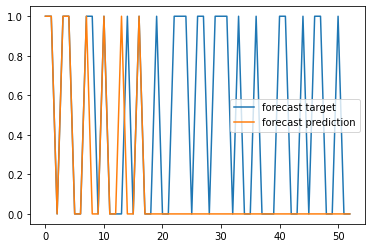

In [547]:
#Multi-step forecast
validation_target = Y_test
validation_predictions = []

last_x = X_train[-1]

while len(validation_predictions) < len(validation_target):
    
    p = model.predict(last_x.reshape(1,T,3))[0,0] #1x1 array -> Scalar

    validation_predictions.append(p)
    
    last_x = np.roll(last_x, -1) #Shifts element -1 (to the left)
    last_x[-1] = p #P is most recent prediction of Y-hat

binary_val_pred = [round(num) for num in validation_predictions]
plt.plot(validation_target, label='forecast target')
plt.plot(binary_val_pred, label='forecast prediction')
plt.legend()
error = np.mean( validation_target != binary_val_pred )
print(error)

## 3.2 Multi-step predictions weekwise

I belive that in order to make use of this model, predicting one week at a time would be enough. I devised this algorithm to present "real data" to the model every 7 days, simulating time passing in order to test the accuracy of subsequent weeks.<br><br>
Wee see that the model never defaults to random walks when given real data every 7 days, therefor it keeps giving predictions of positive or negative price returns with an average error of 0.32. The green diamonds marks every new week, or when the model gets to look at new data. 

7 steps total error: 0.3265306122448979


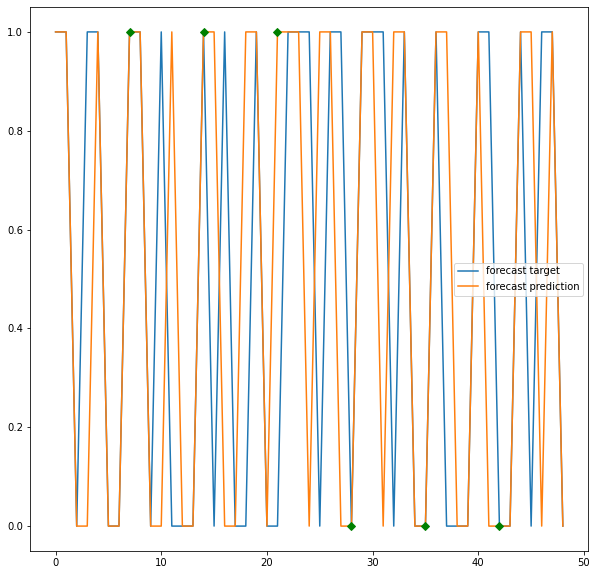

In [623]:
predictedSteps = 7
error_test = 0
nError_test = 0
weekly_validation_predictions= []
for x in range(len(Y_test)//predictedSteps):

    test_weekly_preds = []
    if(x == 0):
        last_x = X_train[-1]
        val_target_test = Y_test[0:predictedSteps]  
    else:
        val_target_test = Y_test[(x*predictedSteps):(x*predictedSteps+predictedSteps)]
        last_x = X_test[(x*predictedSteps)]
    val_predict_test = []

    while len(val_predict_test) < len(val_target_test):

        p_test = model.predict(last_x.reshape(1,T,3))[0,0] #1x1 array -> Scalar
        val_predict_test.append(p_test)
        test_weekly_preds.append(p_test)
        weekly_validation_predictions.append(p_test)

        last_x = np.roll(last_x, -1) #Shifts element -1 (to the left)
        last_x[-1] = p #P is most recent prediction of Y-hat

    binary_val_pred2 = [round(num) for num in test_weekly_preds]
    newerror = np.mean( val_target_test != binary_val_pred2 )
    error_test += newerror
    nError_test += 1
totalTestErrorPrediction = error_test / nError_test
print(predictedSteps,"steps total error:",totalTestErrorPrediction)


plt.figure(figsize=(10,10))
weekly_validation_predictions = [round(num) for num in weekly_validation_predictions]
plt.plot(Y_test[0:49], label='forecast target')
plt.plot(weekly_validation_predictions, label='forecast prediction')
markers_on = [7, 14, 21, 28, 35, 42]
plt.plot(weekly_validation_predictions, 'gD', markevery=markers_on)
plt.legend()

In [626]:
from sklearn.metrics import confusion_matrix
confusion_matrix(weekly_validation_predictions, Y_test[0:49])

array([[16,  8],
       [ 8, 17]], dtype=int64)

## 3.3 Algorithm to test predicted results of other steps

Peeking at real data every 7 days gave decent results, how good will the model predict if we show it real data for other intervals of time? I adjusted the algorithm to do a multistep prediction from 2 to the max amount of possible divisions with the Y_test partition. 

In [631]:
predictedSteps =2
absoluteTotalError = 0
absoluteTotalErrorN = 0
abovefifty = 0
for j in range(25):
    error_test = 0
    nError_test = 0
    for x in range(len(Y_test)//predictedSteps):

        test_weekly_preds = []
        if(x == 0):
            last_x = X_train[-1]
            val_target_test = Y_test[0:predictedSteps]  
        else:
            val_target_test = Y_test[(x*predictedSteps):(x*predictedSteps+predictedSteps)]
            last_x = X_test[(x*predictedSteps)]
        val_predict_test = []

        while len(val_predict_test) < len(val_target_test):

            p_test = model.predict(last_x.reshape(1,T,3))[0,0] #1x1 array -> Scalar
            val_predict_test.append(p_test)
            test_weekly_preds.append(p_test)

            last_x = np.roll(last_x, -1) #Shifts element -1 (to the left)
            last_x[-1] = p_test #P_test is most recent prediction of Y-hat

        binary_val_pred2 = [round(num) for num in test_weekly_preds]
        newerror = np.mean( val_target_test != binary_val_pred2 )
        error_test += newerror
        nError_test += 1
    totalTestErrorPrediction = error_test / nError_test
    if(totalTestErrorPrediction >= 0.5):
        abovefifty +=1
    absoluteTotalError += totalTestErrorPrediction
    absoluteTotalErrorN += 1
    print(predictedSteps,"predictedSteps:",totalTestErrorPrediction)

    predictedSteps += 1

print("Total error across all predicted steps:",absoluteTotalError/absoluteTotalErrorN)
print("Tests above 0.5 error:", abovefifty,"/",predictedSteps)

2 predictedSteps: 0.40384615384615385
3 predictedSteps: 0.41176470588235287
4 predictedSteps: 0.4230769230769231
5 predictedSteps: 0.4000000000000001
6 predictedSteps: 0.4583333333333333
7 predictedSteps: 0.3265306122448979
8 predictedSteps: 0.5625
9 predictedSteps: 0.39999999999999997
10 predictedSteps: 0.54
11 predictedSteps: 0.36363636363636365
12 predictedSteps: 0.375
13 predictedSteps: 0.2692307692307693
14 predictedSteps: 0.3333333333333333
15 predictedSteps: 0.4444444444444445
16 predictedSteps: 0.375
17 predictedSteps: 0.43137254901960786
18 predictedSteps: 0.3611111111111111
19 predictedSteps: 0.18421052631578946
20 predictedSteps: 0.325
21 predictedSteps: 0.38095238095238093
22 predictedSteps: 0.2727272727272727
23 predictedSteps: 0.21739130434782608
24 predictedSteps: 0.4375
25 predictedSteps: 0.36
26 predictedSteps: 0.3076923076923077
Total error across all predicted steps: 0.37458616364779473
Tests above 0.5 error: 2 / 27


Here we see the total error, with each passing increasing the steps to predict before looking at new data. We see that predicting 7 steps each pass gives error 0.32 as shown earlier, which is below the average overall error of 0.37. Interestingly enough predicting 19 steps per pass gave the best result of only 0.18 error!<br><br>
Given that only 2/27 passes of the algorithm showed an error above 0.5 i belive there is some pattern of which the model can classify future binary price returns.

## 3.4 Multi-step prediction with 19 steps

Let test the multi-step classifier using the same algorithm as with 7, but increasing the steps before showing the model "real data" to 19.

19 steps total error: 0.18421052631578946


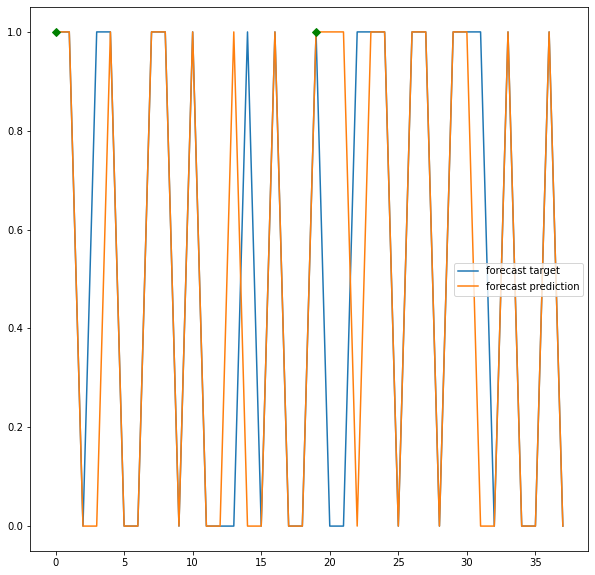

In [632]:
predictedSteps = 19
error_test = 0
nError_test = 0
weekly_validation_predictions_2 = []
for x in range(len(Y_test)//predictedSteps):

    test_weekly_preds = []
    if(x == 0):
        last_x = X_train[-1]
        val_target_test = Y_test[0:predictedSteps]  
    else:
        val_target_test = Y_test[(x*predictedSteps):(x*predictedSteps+predictedSteps)]
        last_x = X_test[(x*predictedSteps)]
    val_predict_test = []

    while len(val_predict_test) < len(val_target_test):

        p_test = model.predict(last_x.reshape(1,T,3))[0,0] #1x1 array -> Scalar
        val_predict_test.append(p_test)
        test_weekly_preds.append(p_test)
        weekly_validation_predictions_2.append(p_test)

        last_x = np.roll(last_x, -1) #Shifts element -1 (to the left)
        last_x[-1] = p_test #P_test is most recent prediction of Y-hat

    binary_val_pred2 = [round(num) for num in test_weekly_preds]
    newerror = np.mean( val_target_test != binary_val_pred2 )
    error_test += newerror
    nError_test += 1
totalTestErrorPrediction = error_test / nError_test
print(predictedSteps,"steps total error:",totalTestErrorPrediction)


plt.figure(figsize=(10,10))
weekly_validation_predictions_2 = [round(num) for num in weekly_validation_predictions_2]
plt.plot(Y_test[0:38], label='forecast target')
plt.plot(weekly_validation_predictions_2, label='forecast prediction')
markers_on = [0, 19]
plt.plot(weekly_validation_predictions_2, 'gD', markevery=markers_on)
plt.legend()

As with the earlier multi-step classifier, the green diamonds marks where the model gets to peek at real data. Since there is 52 days in Y_test, we can only do two passes of the algorithm while predicting 19 steps at a time. Even tho the predicted sequences are longer, the results are even better than the 7-step-forecast with an error of only around 18%.

In [634]:
confusion_matrix(weekly_validation_predictions_2, Y_test[0:38])

array([[15,  4],
       [ 3, 16]], dtype=int64)

# 3.5 Evaluation on the 18 days of data since training model

Since 18 days have passed sinced training the final model, let's predict theese 18 days based on the last sequence T of X_test. The data is collected and preprocessed the same way as earlier, except now a mask is applied to select dates after 2021-04-27, which is the last point of data in X/Y_test. After that we select the column "Return" as binary, of which we can compare the validations with.

In [82]:
jsonSoldItems = requests.get("https://api.nexushub.co/wow-classic/v1/items/shazzrah-horde/elixir-of-the-mongoose/prices?timerange=500")
data = jsonSoldItems.json()

with open('new_data.json', 'w') as f:
    json.dump(data['data'], f)
    
new_df = pd.read_json('new_data.json')
new_df.to_csv('new_data.csv')
new_df = pd.read_csv('new_data.csv')

new_df['scannedAt'] = pd.to_datetime(new_df['scannedAt'])
new_df['date'] = new_df['scannedAt'].dt.date
new_df['date'] = pd.to_datetime(new_df['date'])
new_df = new_df.groupby(pd.Grouper(key='date',freq='D')).sum()

for i in new_df.index:
    new_df.at[i, 'avgBuyout']=new_df.at[i,'marketValue']/new_df.at[i,'quantity'].astype(float)

new_df['prevBuyout'] = new_df['avgBuyout'].shift(1)
new_df['Return'] = (new_df['avgBuyout'] - new_df['prevBuyout']) / new_df['prevBuyout']

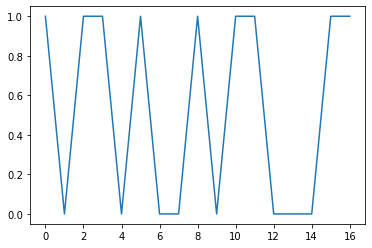

In [124]:
start_date = '2021-04-27'
mask = (new_df.index > start_date)
filtered_df=new_df['Return'].loc[mask]
    
for i in range(len(filtered_df)):
    if filtered_df[i] > 0:
        filtered_df[i]=1
    else:
        filtered_df[i]=0
filtered_df.reset_index(drop=True, inplace=True)
plt.plot(filtered_df)

Above is the plotted Returns binary value from 2021-04-28 until 2021-05-15. Let's now load the model previously trained to test it out with a multi-step prediction.

In [115]:
model = tf.keras.models.load_model('AH_LSTM.h5')

0.35294117647058826


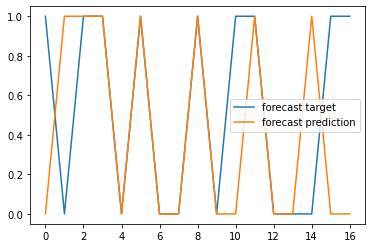

In [125]:
validation_target = filtered_df
validation_predictions = []

last_x = X_test[-1]

while len(validation_predictions) < len(validation_target):
    
    p = model.predict(last_x.reshape(1,T,3))[0,0]

    validation_predictions.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

binary_val_pred = [round(num) for num in validation_predictions]
plt.plot(validation_target, label='forecast target')
plt.plot(binary_val_pred, label='forecast prediction')
plt.legend()
error = np.mean( validation_target != binary_val_pred )
print(error)

**Test**<br>
Shown above are the results of a multi-step prediction of the entire data(17 days) with only showing the model the last sequence from X_Test. Since we want the model to predict one result on the absolute last data of the original data, we show it the test partition instead of train.<br><br>

**Results**
With 11 correct predictions out of 17, or an error of around 35% the model predicts with similar success as earlier tests. 

# 4.0 Discussion

**Probabilities**:<br>
I have done many runs of this algorithm, and this particular one is a "lucky" one given the low errors on multi-step predictions. Earlier worse fitted models has however always showed average error values under 0.5. Given this we cannot say how many predicted time steps to use for an optimal model, as it shifts each passing. I have however notice that 7 days consequently gives error at around 0.32-0.42 (looking at prior models). Since we wont know the results before we have real data, one should probably stick with one range of timesteps classified, and weekly classifications should be sufficient if one where to invest gold based on the models results.<br><br>

**Ethics**:<br>
I originally planned to test this model out for real by investing gold in the Auction House, after giving it some thought i decided not to do this. I concluded this would be "scalping", simply making gold off other players who needs the resources, which seems unethical to me.<br><br>

**Cyclical?**:<br>
I belive that there is a "weak" cyclical pattern in the price data, if we look at the plotted models of all multi-step predictions you can clearly see a pattern of up/down. Interestingly we also see that where our model predicts wrongly, it looks like the model sees the pattern but is off a day. I.e. the model predicts based on a correct pattern, but does the prediction wrong in time, or at the wrong timestep. This leads me to belive we could make this model even better, but for that i'm going to have to learn more about Machine Learning.

# 5.0 Results

## Question of discovery:
1. Are the price movements on World of Warcrafts Elixir of the Mongoose random walks?<br><br>
2. Will an LSTM model be able to binary classify price returns at a accuracy higher than 0.5 for Elixir of the Mongoose without overfitting to the training data?<br><br>
3. Can i create a model which a player could use to make gold of the Auction House by classifying the price return of Elixir of the Mongoose?<br><br>

## Answers:
1. My conclusion is that they are not random walks, given that the model predicts at an average of 0.37 error across 2-26 timesteps on the validation partition. When predicting the 18 days of data since training the model resulted in an error of 0.35. This leads me to belive that there are some pattern in the data of which the model can frequently forecast sequences of an error less than 0.5. <br><br>
2. Yes. For using the model practically one should predict using the same timesteps given that we wont know the results before the future. The tests indicate that the model does classify with an error less than 0.5 while classifying returns 24/26 times for timesteps of 2-26. <br><br>
3. Since i have decided not to test this due to ethical reasons, this question will be left unanswered.

## 5.1 Post Mortem

This project was nothing like i expected, after reading tech articles i belived creating a model with 0.9+ accuracy would be easy for a digital price prediction. I have since learned many things, and realised the vast depth of machine learning. Along this journey, i've realised that learning one thing opens up 3 new things you're clueless about. Which is really cool!<br><br>
Given that neural networks are brand new to me, alot of the exploration was done with "trial by fire", i.e. "let's try this and see what happens". This is fine for me, and i belive it's a fun way of learning things. But.. For future projects, i'm going to learn more about various tests that can indicate selection of better hyperparameters and less "trial by fire". <br><br>